<a href="https://colab.research.google.com/github/Vasil255/PesosAjedrezGardner5x5/blob/main/AjedrezDeGardenerConDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agente capaz de jugar Ajedrez de Gardner 5x5 con algoritmo DeepQ-Learning (DQN)
En este cuaderno se presenta la implementación de un agente de Inteligencia Artificial capaz de aprender y jugar al **Ajedrez de Gardner**, una version simplificada del ajedrez que utiliza un tablero de **5x5** en vez del tradicional 8x8. Este entorno reduce el espacio de estados, permitiendo validar algoritmos de aprendizaje complejo sin los requisitos computacionales masivos del ajedrez estándar.

Claude Shannon, en su artículo “Programming a Computer for Playing Chess” (1950), sentó las bases de la computación aplicada a juegos. En él, diferenció dos filosofías de diseño:


*   **Estrategia A (Fuerza Bruta)**: Basada en la búsqueda exhaustiva de todas las variantes posibles hasta una profundidad determinada. Es la lógica que dio vida a Deep Blue y que hoy, refinada con "poda" de árboles, utiliza Stockfish.
*   **Estrategia B (Búsqueda Selectiva)**: Basada en la intuición. Shannon observó que los maestros no calculan más, sino mejor: descartan jugadas mediocres y solo profundizan en las 2 o 3 más prometedoras. Este enfoque es el corazón de modelos modernos como AlphaZero y es el que exploramos en este proyecto mediante redes neuronales.

**1. Objetivos del cuaderno**

*   **Modelado del Entorno**: Implementar las reglas completas del Ajedrez de Gardner 5x5.
*  **Aprendizaje Reforzado**: Entrenar un agente que maximice una función de recompensa basada en los valores de pieza propuestos por Claude Shannon en su artículo (Rey=200, Dama=9, Torre=5, Alfil/Caballo=3, Peón=1).
*   **Arquitectura MLP**: Evaluar la capacidad de una red neuronal densa para procesar el tablero de forma plana y generar jugadas tácticas mediante el aprendizaje de la función de valor Q.
*   **Arquitectura CNN**: Identificar las limitaciones del procesamiento lineal de datos y plantear la necesidad de filtros espaciales para capturar patrones geométricos (diagonales, filas y saltos).

**2. Metodología**

El agente opera bajo Aprendizaje Reforzado (RL), en un ciclo de:


1.   **Estado (S)**: Representación numérica de la posición actual de las piezas.
2.   **Acción (A)**: Selección de un movimiento legal entre las 625 combinaciones posibles del tablero 5x5.
3.   **Recompensa (R)**: Feedback inmediato basado en capturas, jaque mate o penalizaciones por tiempo.

Para garantizar la estabilidad del aprendizaje, se han implementado tres mecanismos clave del algoritmo DQN:


*   **Experience Replay (Memoria de Experiencia)**: El agente guarda partidas pasadas y "estudia" lotes aleatorios de recuerdos para evitar olvidar jugadas críticas.
*   **Target Network (Red de Objetivo)**: Una copia de la red neuronal que se mantiene estable mientras la red principal aprende, evitando que las predicciones oscilen bruscamente.
*   **Epsilon-Greedy (ϵ)**: Un sistema de decaimiento que permite al agente pasar de una Exploración total (jugar al azar para descubrir el mundo) a una Explotación del conocimiento (usar su instinto entrenado para ganar).

**3. Consideraciones sobre el algoritmo: ¿Es DQN óptimo para el Ajedrez?**

Es importante señalar que, aunque el Deep Q-Learning (DQN) es un hito en el aprendizaje por refuerzo, presenta limitaciones intrínsecas cuando se aplica a juegos de estrategia pura como el ajedrez:

*  **Ausencia de Búsqueda (Look-ahead):** A diferencia de motores como Stockfish (Estrategia A) o AlphaZero (que combina Redes Neuronales con Monte Carlo Tree Search), un agente DQN puro toma decisiones basadas únicamente en el valor Q del estado actual. Carece de una fase de "planificación" o simulación de jugadas futuras, lo que dificulta la gestión de tácticas a largo plazo o sacrificios de piezas.
*  **Complejidad del Espacio de Acciones:** En el ajedrez, incluso en 5x5, el número de movimientos legales varía drásticamente en cada turno. Mapear un espacio de salida fijo (625 neuronas) donde la mayoría de las acciones son ilegales en un momento dado, ralentiza significativamente la convergencia del modelo.
*   **Enfoque Experimental:** Por tanto, este proyecto no busca competir con motores de búsqueda de élite, sino actuar como un estudio experimental. El objetivo es explorar los límites de la aproximación de funciones mediante redes neuronales (MLP y CNN) para capturar la "intuición" posicional y entender cómo el agente gestiona la recompensa inmediata frente a la victoria final en un entorno de información perfecta.


















## Bloque 1: Importación de librerías y Configuración del Dispositivo

In [ ]:
# Manipulación de datos y cálculo numérico
import numpy as np
import pandas as pd
import random
import copy
import time
from collections import deque

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Visualización y Notebook UI
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

# Configuración de dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Trabajando con: {device}")

Trabajando con: cuda


## Bloque 2: El Entorno (Gardner Chess 5x5)
En este bloque se define la clase GardnerChessEnv, que actúa como el núcleo del sistema o "árbitro". Su función es gestionar el estado del tablero, aplicar las reglas del ajedrez y proporcionar el feedback (recompensas) necesario para que el agente aprenda mediante Reinforcement Learning.

**1. Representación y Lógica**

*  **Representación del Estado**: El tablero de 5×5 se inicializa con la configuración clásica de Gardner. El estado se entrega al modelo como un vector plano (tensor) de 25 elementos, donde cada pieza tiene un valor numérico asignado (Rey: ±200, Dama: ±9, Torre: ±5, Alfil: ±4, Caballo: ±3, Peón: ±1).
*  **Lógica de Piezas**: Se ha implementado el movimiento completo para cada pieza, incluyendo el cálculo de trayectorias para piezas de largo alcance (Torre, Alfil, Dama) y el salto en "L" del Caballo.
* **Máscara de Acciones (Action Masking)**: Para optimizar el aprendizaje, el entorno genera una máscara binaria de 625 posibles movimientos (25 origen ×25 destino). Esto permite que el agente solo evalúe jugadas legales, evitando que pierda tiempo explorando movimientos físicamente imposibles.

**2. Función de Recompensa (Reward Shaping)**

Para guiar el aprendizaje del agente en un espacio de estados extenso, se ha diseñado una función de recompensa densa basada en los principios de Shannon y reglas de incentivos tácticos:

*   **Captura de piezas**: Recompensa inmediata proporcional al valor de la pieza capturada.
*   **Jaque Mate (Victoria Máxima)**: +200.0 puntos, incentivando la finalización de la partida.
*   **Bonus por Jaque:** Se otorgan +10.0 puntos al poner al Rey enemigo bajo amenaza, fomentando un estilo de juego agresivo.
* **Promoción del Peón:** +5.0 puntos al alcanzar la última fila (con promoción automática a Dama), premiando el avance de peones.
* **Eficiencia Temporal:** Una penalización constante de −0.05 por cada movimiento realizado. Esto presiona a la IA para ganar de la forma más rápida y eficiente posible.
*  **Penalización por Error/Empate:** −100.0 puntos si la partida termina en tablas, por límite de pasos o por repetición, obligando al agente a evitar el estancamiento.

**3. Reglas y Simplificaciones**

Para facilitar la convergencia del algoritmo DQN sin sacrificar la esencia estratégica, se han aplicado las siguientes reglas:

*  **Simplificaciones:** Se omiten el enroque, el doble paso inicial del peón y la captura al paso (en passant).
*  **Restricción de Jaque:** Un movimiento solo es legal si, tras realizarlo, el Rey del jugador activo no queda bajo ataque. Además, se ha implementado una restricción de proximidad para evitar que los dos Reyes se sitúen en casillas adyacentes.
*   **Condiciones de Finalización:**

        Triple Repetición: Si una posición se repite 3 veces, la partida termina (evita bucles infinitos).

        Límite de Pasos: Se establece un máximo de 100 movimientos por partida para garantizar la fluidez del entrenamiento.







In [ ]:
class GardnerChessEnv:
    def __init__(self):
        self.size = 5
        self.P, self.N, self.B, self.R, self.Q, self.K = 1, 3, 4, 5, 9, 200
        self.max_steps = 100
        self.reset()

    def reset(self):
        self.board = np.array([[-5,-3,-4,-9,-200],[-1,-1,-1,-1,-1],[0,0,0,0,0],[1,1,1,1,1],[5,3,4,9,200]])
        self.turn, self.current_step, self.history = 1, 0, {}
        return self.get_state()

    def step(self, action_idx):
        self.current_step += 1
        r1, c1 = (action_idx // 25) // 5, (action_idx // 25) % 5
        r2, c2 = (action_idx % 25) // 5, (action_idx % 25) % 5
        piece, target = self.board[r1, c1], self.board[r2, c2]

        reward = abs(target) if target != 0 else 0
        self.board[r2, c2], self.board[r1, c1] = piece, 0

        if abs(piece) == 1 and (r2 == 0 or r2 == 4):
            self.board[r2, c2] = 9 * (1 if piece > 0 else -1)
            reward += 5.0

        next_p = -self.turn
        board_state = tuple(self.board.flatten())
        self.history[board_state] = self.history.get(board_state, 0) + 1

        if self.history[board_state] >= 3: return self.get_state(), -100.0, True

        in_check = self.is_in_check(next_p)
        if in_check: reward += 10.0

        legal_moves = self.get_legal_moves(next_p)
        done = len(legal_moves) == 0 or self.current_step >= self.max_steps

        if len(legal_moves) == 0:
            reward = 200.0 if in_check else -100.0
        elif self.current_step >= self.max_steps:
            reward = -100.0

        self.turn = next_p
        return self.get_state(), reward - 0.05, done

    def find_king(self, p):
        pos = np.where(self.board == 200*p)
        return (pos[0][0], pos[1][0]) if len(pos[0]) > 0 else None

    def is_in_check(self, p):
        kp = self.find_king(p)
        if not kp: return True

        opp_kp = self.find_king(-p)
        if opp_kp:
            dist_r = abs(kp[0] - opp_kp[0])
            dist_c = abs(kp[1] - opp_kp[1])
            if dist_r <= 1 and dist_c <= 1:
                return True

        for r in range(5):
            for c in range(5):
                if self.board[r, c] * p < 0:
                    rival_moves = self._generate_moves_raw(r, c)
                    for _, target in rival_moves:
                        if target == kp:
                            return True
        return False

    def get_legal_moves(self, p):
        moves = []
        for r in range(5):
            for c in range(5):
                if self.board[r,c]*p > 0:
                    for m in self._generate_moves_raw(r, c):
                        old_t = self.board[m[1]]
                        self.board[m[1]], self.board[r,c] = self.board[r,c], 0
                        if not self.is_in_check(p): moves.append(((r,c), m[1]))
                        self.board[r,c], self.board[m[1]] = self.board[m[1]], old_t
        return moves

    def _generate_moves_raw(self, r, c):
        p = self.board[r,c]; moves = []
        if abs(p)==1: # Peón
            d = -1 if p>0 else 1
            if 0<=r+d<5 and self.board[r+d,c]==0: moves.append(((r,c),(r+d,c)))
            for dc in [-1,1]:
                if 0<=r+d<5 and 0<=c+dc<5 and self.board[r+d,c+dc]*p < 0: moves.append(((r,c),(r+d,c+dc)))
        elif abs(p)==3: # Caballo
            for dr, dc in [(-2,-1),(-2,1),(-1,-2),(-1,2),(1,-2),(1,2),(2,-1),(2,1)]:
                nr, nc = r+dr, c+dc
                if 0<=nr<5 and 0<=nc<5 and self.board[nr,nc]*p <= 0: moves.append(((r,c),(nr,nc)))
        elif abs(p) in [4, 5, 9]: # Alfil, Torre, Reina
            dirs = []
            if abs(p) != 4: dirs += [(-1,0),(1,0),(0,-1),(0,1)]
            if abs(p) != 5: dirs += [(-1,-1),(-1,1),(1,-1),(1,1)]
            for dr, dc in dirs:
                for i in range(1, 5):
                    nr, nc = r+dr*i, c+dc*i
                    if 0<=nr<5 and 0<=nc<5:
                        if self.board[nr,nc]*p <= 0: moves.append(((r,c),(nr,nc)))
                        if self.board[nr,nc] != 0: break
                    else: break
        elif abs(p)==200: # Rey
            for dr in [-1,0,1]:
                for dc in [-1,0,1]:
                    if dr==0 and dc==0: continue
                    nr, nc = r+dr, c+dc
                    if 0<=nr<5 and 0<=nc<5 and self.board[nr,nc]*p <= 0: moves.append(((r,c),(nr,nc)))
        return moves

    def get_state(self):
        # Fíjate que estas líneas tienen 4 espacios de sangría respecto al 'def'
        board_view = self.board.copy()

        # Si es el turno de las negras (-1), volteamos la perspectiva
        if self.turn == -1:
            # Multiplicamos por -1 (piezas negras pasan a ser positivas)
            # y giramos el tablero (axis=0 es vertical)
            board_view = -np.flip(board_view, axis=0)

        return torch.FloatTensor(board_view.flatten()).unsqueeze(0).to(device)

    def get_action_mask(self):
        mask = np.zeros(625)
        for m in self.get_legal_moves(self.turn):
            mask[(m[0][0]*5 + m[0][1])*25 + (m[1][0]*5 + m[1][1])] = 1
        return mask

## Bloque 3: La Red Neuronal (Arquitectura MLP)
Aqui se define el cerebro del agente con una red neuronal MLP (Multi-Layer Perceptron). La misión es aprender la Función de Valor Q que estima la recompensa futura que obtendrá el agente por cada movimiento posible dado un estado del tablero. Este es un efoque de Estrategia B debido a que la red neuronal no intentara calcular todas las variantes hasta el final de la partida por fuerza bruta sino que utilizara su "intuición" entrenada para asignar un valor a cada jugada en el presente y así filtrar el espacio de búsqueda enfocandose solo en los que prevee como ganadores.

En cuanto a la arquitectura utilizada esta se compòne de las siguientes capas:


*  **Capa de Entrada (25 neuronas)**: La red recibe el tablero de 5×5 "aplanado" en un vector de 25 números. Cada número representa la pieza presente en esa casilla (según los valores de Shannon).
*   **Capas Ocultas (512 y 1024 neuronas)**: Mediante funciones de activación ReLU, la red intentara encontrar correlaciones entre las posiciones de las piezas.
*  **Capa de Salida (625 neuronas)**: La red genera 625 valores de salida, uno por cada posible combinación de movimiento (25 origen×25 destino). El movimiento con el valor más alto (Q-Value) es el que la IA considera mejor.






In [ ]:
class QNetwork5x5(nn.Module):
    def __init__(self):
        super(QNetwork5x5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(25, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 625)
        )

    def forward(self, x):
        return self.model(x)

model = QNetwork5x5().to(device)

## Bloque 4: Implementación del Algoritmo Deep Q-Learning (DQN)
En esta sección se desarrolla el motor de aprendizaje del agente. El algoritmo DQN permite que una red neuronal aproxime la función de valor Q, la cual estima la recompensa total esperada que un jugador puede obtener a partir de una acción en un estado determinado.

Dado que incluso en un tablero de 5×5 el espacio de estados es inmenso, el aprendizaje por refuerzo profundo es fundamental: permite evaluar la calidad de las posiciones mediante la generalización de la red neuronal, sin necesidad de visitar cada posición posible. Este enfoque es la implementación técnica de la Estrategia B de Shannon.

**Mecanismos clave de estabilidad:**


*   **Experience Replay (Memoria de Experiencia)**: El agente almacena sus transiciones (estado, acción, recompensa, siguiente estado) en un buffer circular (deque). Al entrenar con lotes aleatorios (mini-batches), rompemos la correlación temporal de las partidas, evitando que la red se sesgue por las últimas jugadas realizadas y permitiéndole "reaprender" de situaciones críticas del pasado.
*    **Target Network (Red de Objetivo)**: Para evitar que el entrenamiento diverja, utilizamos una segunda red neuronal (target_net) que actúa como referencia estable para calcular los valores Q objetivo de la Ecuación de Bellman. Esta red se sincroniza con la principal cada 20 episodios, proporcionando un "norte" fijo durante el proceso de optimización.
*   **Estrategia Epsilon-Greedy (ϵ-greedy)**: Gestiona el balance entre Exploración y Explotación. El agente comienza siendo un explorador total (ϵ=1.0), realizando movimientos aleatorios para descubrir el entorno. Mediante un factor de decaimiento, se convierte gradualmente en un jugador estratégico que confía en el conocimiento almacenado en su red neuronal.
*   **Optimizador Adam y función de perdida Huber Loss con 2000 episodios**





In [ ]:
def train_gardner_ai(episodes=5000):
    env = GardnerChessEnv()
    policy_net = QNetwork5x5().to(device)
    target_net = QNetwork5x5().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0005)
    memory = deque(maxlen=10000)
    epsilon, history = 1.0, []

    for ep in range(episodes):
        state = env.reset()
        total_reward, done = 0, False
        while not done:
            mask = env.get_action_mask()
            legal_indices = np.where(mask == 1)[0]
            if len(legal_indices) == 0: break
            if random.random() < epsilon: action = random.choice(legal_indices)
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    q_values[0][mask == 0] = -1e9
                    action = q_values.max(1)[1].item()
            next_state, reward, done = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state, total_reward = next_state, total_reward + reward
            if len(memory) > 128:
                batch = random.sample(memory, 128)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.cat(states).float().to(device)
                actions = torch.tensor(actions).to(device)
                rewards = torch.tensor(rewards).float().to(device)
                next_states = torch.cat(next_states).float().to(device)
                dones = torch.tensor(dones).float().to(device)
                current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                with torch.no_grad():
                    max_next_q = target_net(next_states).max(1)[0]
                    expected_q = rewards + (0.99 * max_next_q * (1 - dones))
                loss = nn.SmoothL1Loss()(current_q.squeeze(), expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        epsilon = max(0.1, epsilon * 0.999)
        if ep % 20 == 0: target_net.load_state_dict(policy_net.state_dict())
        history.append(total_reward)
        if ep % 100 == 0: print(f"Ep {ep} | Reward: {total_reward:.2f} | Eps: {epsilon:.2f}")
    return policy_net, history

model, rewards = train_gardner_ai(2000)

# Código para descargar los pesos
from google.colab import files

# Guardamos el estado del diccionario del modelo en un archivo .pth
torch.save(model.state_dict(), 'modelo_gardner_pesos.pth')

# Descargamos el archivo
files.download('modelo_gardner_pesos.pth')

Ep 0 | Reward: 95.00 | Eps: 1.00
Ep 100 | Reward: 76.45 | Eps: 0.90
Ep 200 | Reward: 262.55 | Eps: 0.82
Ep 300 | Reward: 50.00 | Eps: 0.74
Ep 400 | Reward: 73.00 | Eps: 0.67
Ep 500 | Reward: 55.85 | Eps: 0.61
Ep 600 | Reward: 221.20 | Eps: 0.55
Ep 700 | Reward: -0.80 | Eps: 0.50
Ep 800 | Reward: 89.20 | Eps: 0.45
Ep 900 | Reward: 297.45 | Eps: 0.41
Ep 1000 | Reward: 251.80 | Eps: 0.37
Ep 1100 | Reward: 77.00 | Eps: 0.33
Ep 1200 | Reward: -12.10 | Eps: 0.30
Ep 1300 | Reward: -37.80 | Eps: 0.27
Ep 1400 | Reward: 22.45 | Eps: 0.25
Ep 1500 | Reward: 29.05 | Eps: 0.22
Ep 1600 | Reward: 19.85 | Eps: 0.20
Ep 1700 | Reward: 27.90 | Eps: 0.18
Ep 1800 | Reward: -7.15 | Eps: 0.16
Ep 1900 | Reward: 32.80 | Eps: 0.15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Bloque 5: Evaluación de Resultados y Visualización de Partidas
Para evaluar el rendimiento del agente analizaremos la evolución de la **Recompensa Acumulada** a lo largo de los episodios y se implementara una interfaz visual que permitira visualizar el tablero de Gardner y las jugadas de la IA jugando contra si misma.


1. Gráfica recompensa acumulada

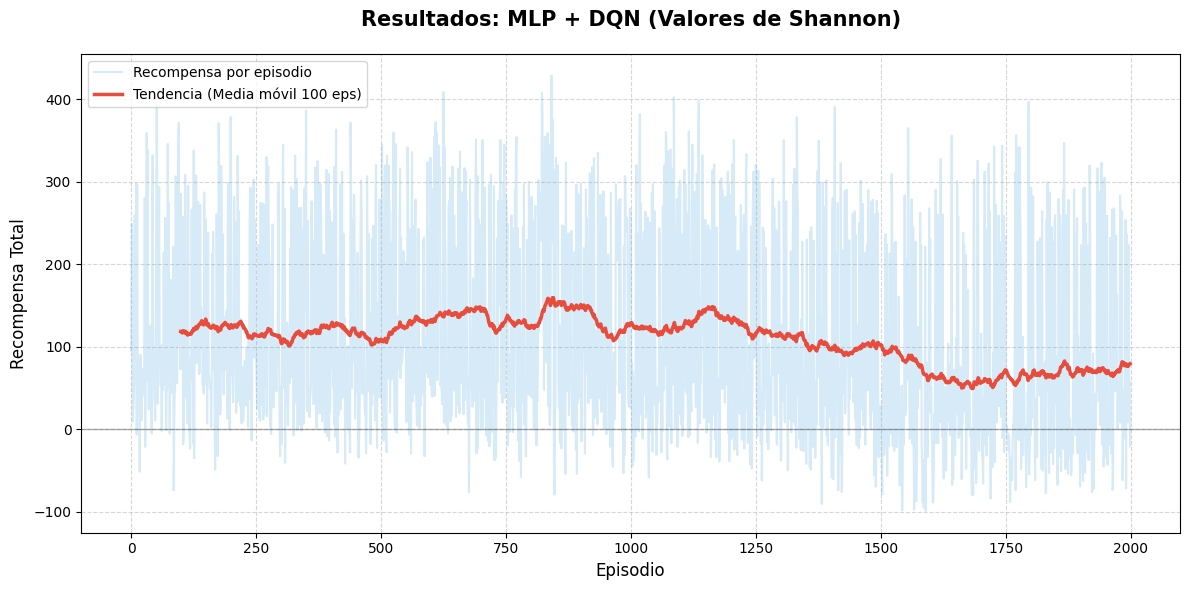

In [ ]:
def plot_results(reward_list, title='Curva de Aprendizaje - Gardner Chess 5x5'):

    plt.figure(figsize=(12, 6))

    plt.plot(reward_list, color='#3498db', alpha=0.2, label='Recompensa por episodio')

    # 2. Calculamos y dibujamos la media móvil para ver la tendencia real
    window_size = 100
    if len(reward_list) >= window_size:
        means = pd.Series(reward_list).rolling(window=window_size).mean()
        plt.plot(means, color='#e74c3c', linewidth=2.5, label=f'Tendencia (Media móvil {window_size} eps)')

    # Estética de la gráfica
    plt.title(title, fontsize=15, pad=20, fontweight='bold')
    plt.xlabel('Episodio', fontsize=12)
    plt.ylabel('Recompensa Total', fontsize=12)
    plt.legend(loc='upper left', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Añadimos una línea horizontal en 0 para referenciar el progreso
    plt.axhline(0, color='black', lw=1, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_results(rewards, title='Resultados: MLP + DQN (Valores de Shannon)')

2. Funciónes para la visualizacion del tablero

In [ ]:
def coord_to_idx_5x5(coord):
    """Convierte coordenadas tipo 'A1' a índices de matriz (fila, col) para 5x5"""
    try:
        coord = coord.upper().strip()
        if len(coord) != 2: return None
        col = ord(coord[0]) - ord('A')
        # En 5x5: fila 5 es índice 0, fila 1 es índice 4
        row = 5 - int(coord[1])

        if 0 <= col < 5 and 0 <= row < 5:
            return row, col
        return None
    except:
        return None

print("Función de conversión de coordenadas 5x5 lista.")

Función de conversión de coordenadas 5x5 lista.


In [ ]:
def get_board_html_5x5(board, move_num, turn, reward, status="", done=False):
    symbols = {0:'', 1:'♙', 3:'♘', 4:'♗', 5:'♖', 9:'♕', 200:'♔',
               -1:'♟', -3:'♞', -4:'♝', -5:'♜', -9:'♛', -200:'♚'}

    # Colores dinámicos
    st_bg = "#dcb35c" if not done else "#ff5252"
    st_col = "#3e2723" if not done else "white"

    # Estilos CSS una sola vez (esto es lo que ahorra memoria)
    css = """
    <style>
        .chess-td { width:50px; height:50px; text-align:center; font-size:35px; border:none; }
        .bg-l { background: #dcb35c; }
        .bg-d { background: #926139; }
        .w { color: white; }
        .b { color: black; }
    </style>
    """

    rows = ""
    for i in range(5):
        row_str = f"<td style='color:#dcb35c; font-weight:bold;'>{5-i}</td>"
        for j in range(5):
            # Lógica compacta de clase: par/impar para color de celda y signo para color de pieza
            bg_cls = "bg-l" if (i+j)%2==0 else "bg-d"
            val = int(board[i][j])
            p_cls = "w" if val > 0 else "b"
            row_str += f'<td class="chess-td {bg_cls} {p_cls}">{symbols.get(val, "")}</td>'
        rows += f"<tr>{row_str}</tr>"

    return f"""
    {css}
    <div style="background:#3e2723; padding:10px; border-radius:8px; width:300px; margin:auto; font-family:sans-serif;">
        <div style="color:#dcb35c; text-align:center; font-size:12px; margin-bottom:5px;">
            MOV: {move_num} | REW: {reward:.1f}
        </div>
        <table style="border-collapse:collapse; margin:auto;">
            {rows}
            <tr style="color:#dcb35c; font-weight:bold; text-align:center;">
                <td></td><td>A</td><td>B</td><td>C</td><td>D</td><td>E</td>
            </tr>
        </table>
        <div style="margin-top:8px; padding:4px; background:{st_bg}; color:{st_col}; text-align:center; font-weight:bold; font-size:12px; border-radius:4px;">
            {status if status else ("Blancas" if turn==1 else "Negras")}
        </div>
    </div>
    """

3. IA VS IA

In [ ]:
def simulate_ia_vs_ia(trained_model, max_moves=80, temperature=0.5):
    env_test = GardnerChessEnv()
    state = env_test.reset()
    done, moves = False, 0
    total_reward = 0

    # Crear el manejador de pantalla inicial
    # Argumentos: board, move_num, turn, reward, status, done
    handle = display(HTML(get_board_html_5x5(env_test.board, 0, 1, 0, "¡Que empiece!")), display_id=True)

    while not done and moves < max_moves:
        mask = env_test.get_action_mask()
        legal_indices = np.where(mask == 1)[0]

        if len(legal_indices) == 0:
            status = "Bloqueo: Sin movimientos"
            break

        with torch.no_grad():
            q_vals = trained_model(state)

            # Filtramos solo los Q de movimientos legales
            legal_q = q_vals[0][legal_indices]

            # Aplicamos Temperatura + Softmax
            # Usamos una temperatura mínima para evitar divisiones por cero o desbordamientos
            temp = max(temperature, 0.01)
            probs = F.softmax(legal_q / temp, dim=0)

            # Selección de acción usando multinomial (más estable que np.random.choice)
            action_idx_in_legal = torch.multinomial(probs, 1).item()
            action = legal_indices[action_idx_in_legal]

        # Guardamos el turno antes de mover para la visualización
        current_turn = env_test.turn

        # Ejecutar movimiento
        state, reward, done = env_test.step(action)
        total_reward += reward
        moves += 1

        # Determinar mensaje de estado
        if done:
            if reward >= 200: status = "¡JAQUE MATE!"
            elif reward <= -100: status = "TABLAS / AHOGADO"
            else: status = "FIN DE PARTIDA"
        else:
            status = "En juego..."

        # ACTUALIZACIÓN VISUAL CORRECTA
        # Pasamos los argumentos por nombre para evitar errores de posición
        html_code = get_board_html_5x5(
            board=env_test.board,
            move_num=moves,
            turn=current_turn, # Mostramos quién acaba de mover
            reward=total_reward,
            status=status,
            done=done
        )
        handle.update(HTML(html_code))

        # Tiempo de espera para seguir la partida
        time.sleep(0.8)

    if moves >= max_moves and not done:
        handle.update(HTML(get_board_html_5x5(env_test.board, moves, env_test.turn, total_reward, "LÍMITE DE MOVIMIENTOS", True)))

# Ejecutar con el modelo
simulate_ia_vs_ia(model, temperature=0.4)

5,♜,,♝,♛,♚
4,♟,♟,♕,♟,♟
3,,,,,
2,♙,♙,♔,♙,♙
1,♖,♞,♗,,
,A,B,C,D,E


**Conclusión y análisis de resultados**

Tras el entrenamiento de 2000 episodios, se observa que el enfoque DQN con arquitectura MLP no ha logrado una convergencia satisfactoria para el Ajedrez de Gardner.

Análisis de la falta de convergencia:


*   **Exploración Ineficiente**: Debido a la inmensidad del espacio de estados, el agente ejecuta movimientos con un alto grado de aleatoriedad. Al no encontrar el "premio" del Jaque Mate de forma recurrente, la red neuronal no logra consolidar una política ganadora.

*   **Problema de Recompensas Dispersas (Sparse Rewards)**: La mayoría de las partidas finalizan en empate por repetición o por alcanzar el límite de movimientos, lo que resulta en una recompensa acumulada estancada (cercana a -100).

*  **Limitaciones del Self-Play**: Al entrenar al agente contra sí mismo desde cero, el sistema sufre el problema del 'ciego guiando al ciego', donde la falta de un oponente con una estrategia sólida impide que el modelo identifique y aprenda patrones tácticos superiores.

*  **Ausencia de Búsqueda**: Se confirma que el Deep Q-Learning puro, al carecer de una fase de planificación o búsqueda hacia adelante (como MCTS), es insuficiente para capturar la profundidad estratégica necesaria incluso en una versión reducida del ajedrez."







### Bloque 6: Mejora del Agente - Arquitectura Convolucional (CNN)
Tras observar que el modelo MLP no lograba generalizar patrones tácticos complejos, se implementó una Red Neuronal Convolucional (CNN). A diferencia del modelo anterior, que ignoraba la estructura bidimensional del ajedrez, la CNN utiliza filtros para detectar dependencias espaciales en filas, columnas y diagonales, imitando de forma más precisa la visión periférica de un jugador humano.
Detalles de la Arquitectura Convolucional:

* **Capa de Entrada (Reshaping)**: La red recibe el vector de 25 elementos y lo transforma dinámicamente en una matriz de 5×5 con 1 canal de profundidad (1,5,5). Esto permite aplicar operaciones de convolución sobre la geometría real del tablero.
* **Capas Convolucionales (32 y 64 filtros)**: Se utilizan dos capas Conv2d con kernels de 3×3 y padding para mantener la dimensión. Estas capas actúan como extractores de características, identificando desde piezas aisladas hasta formaciones defensivas o amenazas de mate.
* **Capa de Aplanamiento (Flattening)**: La información espacial extraída se convierte en un vector denso para su procesamiento final.
* **Capas Densas de Decisión**: Una capa oculta de 512 neuronas integra las características visuales y las mapea hacia el espacio de salida de 625 acciones posibles.















In [ ]:
class QNetworkCNN(nn.Module):
    def __init__(self):
        super(QNetworkCNN, self).__init__()
        # Capas Convolucionales para extraer características espaciales
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Capas Densas para la toma de decisiones final
        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 625)
        )

    def forward(self, x):
        # x llega como [Batch, 25] desde el entorno, lo reformateamos a [Batch, 1, 5, 5]
        x = x.view(-1, 1, 5, 5)
        x = self.conv(x)
        x = x.view(x.size(0), -1) # Aplanamos para la capa lineal
        return self.fc(x)

# Instanciamos el nuevo modelo
model_cnn = QNetworkCNN().to(device)

###Bloque 7: Entrenamiento del Agente CNN

Entrenaremos este modelo durante 2000 episodios.

In [ ]:
def train_gardner_cnn(episodes=3000):
    env = GardnerChessEnv()
    policy_net = QNetworkCNN().to(device)
    target_net = QNetworkCNN().to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.0003)
    memory = deque(maxlen=100000)
    epsilon, history = 1.0, []

    for ep in range(episodes):
        state = env.reset()
        total_reward, done = 0, False

        while not done:
            mask = env.get_action_mask()
            legal_indices = np.where(mask == 1)[0]
            if len(legal_indices) == 0: break

            if random.random() < epsilon:
                action = random.choice(legal_indices)
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    q_values[0][mask == 0] = -1e9
                    action = q_values.max(1)[1].item()

            next_state, reward, done = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state, total_reward = next_state, total_reward + reward

            if len(memory) > 256:
                batch = random.sample(memory, 256)
                s, a, r, ns, d = zip(*batch)
                s, ns = torch.cat(s), torch.cat(ns)
                a = torch.tensor(a).to(device)
                r = torch.tensor(r).to(device)
                d = torch.tensor(d, dtype=torch.float).to(device)

                curr_q = policy_net(s).gather(1, a.unsqueeze(1))
                with torch.no_grad():
                    max_next_q = target_net(ns).max(1)[0]
                    expected_q = r + (0.99 * max_next_q * (1 - d))

                loss = nn.SmoothL1Loss()(curr_q.squeeze(), expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(0.1, epsilon * 0.9994)
        if ep % 20 == 0: target_net.load_state_dict(policy_net.state_dict())
        history.append(total_reward)
        if ep % 100 == 0:
            print(f"Ep {ep} | Recompensa CNN: {total_reward:.2f} | Epsilon: {epsilon:.2f}")

    return policy_net, history

# Lanzar entrenamiento CNN
model_cnn, rewards_cnn = train_gardner_cnn(2000)

# Código para descargar los pesos
from google.colab import files

# Guardamos el estado del diccionario del modelo en un archivo .pth
torch.save(model_cnn.state_dict(), 'modelo_cnn_gardner_pesos.pth')

# Descargamos el archivo a tu ordenador
files.download('modelo_cnn_gardner_pesos.pth')


Ep 0 | Recompensa CNN: 243.80 | Epsilon: 1.00
Ep 100 | Recompensa CNN: -20.05 | Epsilon: 0.94
Ep 200 | Recompensa CNN: 12.25 | Epsilon: 0.89
Ep 300 | Recompensa CNN: 106.00 | Epsilon: 0.83
Ep 400 | Recompensa CNN: 240.60 | Epsilon: 0.79
Ep 500 | Recompensa CNN: -16.00 | Epsilon: 0.74
Ep 600 | Recompensa CNN: 238.25 | Epsilon: 0.70
Ep 700 | Recompensa CNN: 63.00 | Epsilon: 0.66
Ep 800 | Recompensa CNN: 50.00 | Epsilon: 0.62
Ep 900 | Recompensa CNN: 79.20 | Epsilon: 0.58
Ep 1000 | Recompensa CNN: 47.30 | Epsilon: 0.55
Ep 1100 | Recompensa CNN: 220.40 | Epsilon: 0.52
Ep 1200 | Recompensa CNN: 47.80 | Epsilon: 0.49
Ep 1300 | Recompensa CNN: 63.65 | Epsilon: 0.46
Ep 1400 | Recompensa CNN: 258.80 | Epsilon: 0.43
Ep 1500 | Recompensa CNN: 88.15 | Epsilon: 0.41
Ep 1600 | Recompensa CNN: 22.10 | Epsilon: 0.38
Ep 1700 | Recompensa CNN: 238.70 | Epsilon: 0.36
Ep 1800 | Recompensa CNN: 164.00 | Epsilon: 0.34
Ep 1900 | Recompensa CNN: 124.20 | Epsilon: 0.32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bloque 8: Comparativa MLP vs CNN

En este punto se presenta la comparativa entre la recompensa acumulada de los dos enfoques y se visualiza una partida del modelo CNN contra si mismo y otra del modelo MLP- Blancas vs CNN- Negras

1. Gráfica comparativa

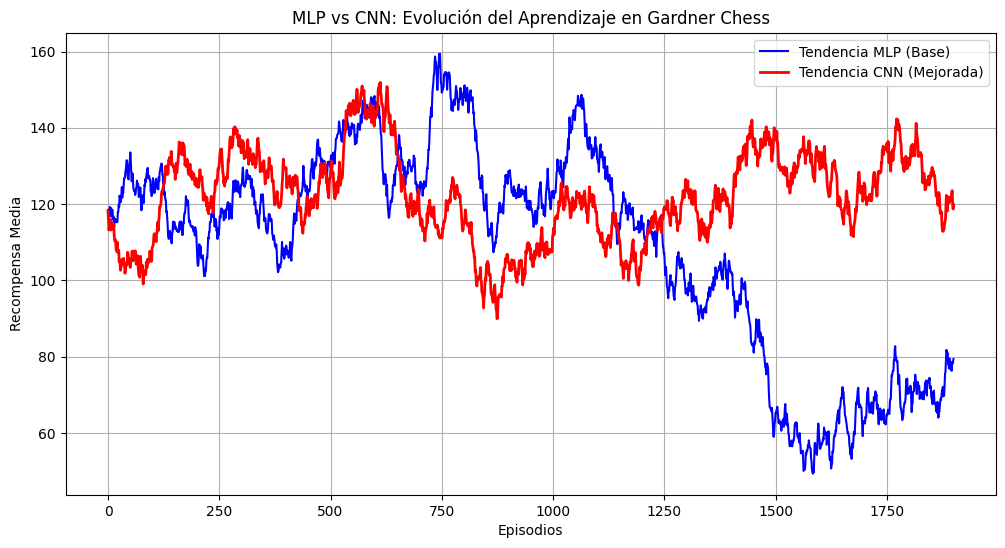

In [ ]:
plt.figure(figsize=(12, 6))
if 'rewards' in locals(): # Recompensas del MLP
    means_mlp = np.convolve(rewards, np.ones(100)/100, mode='valid')
    plt.plot(means_mlp, label='Tendencia MLP (Base)', color='blue', alpha=1)

means_cnn = np.convolve(rewards_cnn, np.ones(100)/100, mode='valid')
plt.plot(means_cnn, label='Tendencia CNN (Mejorada)', color='red', linewidth=2)

plt.title('MLP vs CNN: Evolución del Aprendizaje en Gardner Chess')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Media')
plt.legend()
plt.grid(True)
plt.show()

2. Partida CNN vs CNN

In [ ]:
simulate_ia_vs_ia(model_cnn, max_moves=70, temperature=0.5)

5,,,,♔,
4,,,,,
3,,,,,
2,,,,,
1,,,,♚,
,A,B,C,D,E


3. Partida MLP vs CNN

In [ ]:
def play_models_battle(model_white, model_black, max_moves=80, temperature=0.7):
    # Definimos el entorno como env_battle
    env_battle = GardnerChessEnv()
    state = env_battle.reset()
    done, moves, r = False, 0, 0

    # Manejador visual (usando env_battle)
    handle = display(HTML(get_board_html_5x5(env_battle.board, 0, 1, 0)), display_id=True)

    while not done and moves < max_moves:
        # Elegir el modelo según el turno: Blancas (1) o Negras (-1)
        current_model = model_white if env_battle.turn == 1 else model_black

        mask = env_battle.get_action_mask()
        legal_indices = np.where(mask == 1)[0]

        if len(legal_indices) == 0: break

        with torch.no_grad():
            # Predicción de valores Q
            q_values = current_model(state)

            # --- LÓGICA SOFTMAX (Probabilística) ---
            legal_q_values = q_values[0][legal_indices]
            probs = F.softmax(legal_q_values / temperature, dim=0)
            action = np.random.choice(legal_indices, p=probs.cpu().numpy())

        # Ejecutar movimiento
        state, r, done = env_battle.step(action)
        moves += 1

        # Actualización visual
        handle.update(HTML(get_board_html_5x5(env_battle.board, moves, env_battle.turn * -1, r, done)))
        time.sleep(0.7)

# Blancas: model (MLP) | Negras: model_cnn (CNN)
play_models_battle(model, model_cnn, temperature=0.6)

5,,♞,♛,,
4,♜,,,♚,♟
3,♙,♔,♘,♟,
2,,,,♙,
1,♛,,♗,,
,A,B,C,D,E


**Conclusión y análisis de resultados**

Esta segunda arquitectura ha logrado mejorar la media de la recompensa acumulada, especialmente en las ultimas epocas del entrenamiento. Aun asi, el enfoque sigue sin ser capaz de captar la complejidad tecnica del ajedrez, realizando capturas aleatorias y no siendo capaz de dar jaque mate aun logrando una ventaja abrumadora en ciertos puntos de la partida.

## Bloque 9: Mejoras
Para mejorar los resultados, en este punto se añaden otras mejoras a los entrenamientos. Por un lado se tratara el tablero envez de como una matriz simple como un tensor de 12 planos de 5x5 donde cada plano presenta una pieza. Esto permite a la red identificar patrones de mejor manera y es la logica que se sigue en los motores de ajedrez avanzados como alpha zero.


**Arquitectura de Red "Pro"**

La nueva clase QNetworkPro incorpora técnicas de regularización y estabilidad:

* **Batch Normalization**: Se añade tras cada capa convolucional para normalizar las activaciones, permitiendo un entrenamiento más rápido y reduciendo la sensibilidad a la inicialización de pesos.
*  **Profundidad Incremental**: Pasamos de 64 a 128 filtros para capturar abstracciones tácticas de mayor nivel.
*  **Dropout (0.2)**: Técnica de regularización que desactiva aleatoriamente el 20% de las neuronas durante el entrenamiento. Esto obliga a la red a no depender de rutas específicas de datos, previniendo el overfitting (sobreajuste).
* **Double DQN (DDQN)**: Aunque la arquitectura de la red es la base, el sistema está preparado para la lógica de Doble Red. Esta técnica utiliza la policy_net para seleccionar la mejor acción y la target_net para evaluarla, mitigando el sesgo de sobreestimación de los valores Q típico del DQN estándar













In [ ]:
def board_to_multichannel(state_tensor):
    """
    Convierte el tablero plano (1, 25) en una representación espacial (1, 12, 5, 5).
    Los canales 0-5 representan piezas blancas y 6-11 piezas negras.
    """
    batch_size = state_tensor.size(0)
    board = state_tensor.view(batch_size, 5, 5)

    # Contenedor de 12 canales (6 tipos de piezas x 2 colores)
    multichannel = torch.zeros((batch_size, 12, 5, 5), device=device)

    # Piezas: Peón(1), Caballo(3), Alfil(4), Torre(5), Reina(9), Rey(200)
    pieces = [1, 3, 4, 5, 9, 200]

    for i, p in enumerate(pieces):
        # Canales 0-5: Piezas Blancas
        multichannel[:, i, :, :] = (board == p).float()
        # Canales 6-11: Piezas Negras
        multichannel[:, i + 6, :, :] = (board == -p).float()

    return multichannel

# --- ARQUITECTURA DE LA RED  ---
class QNetworkPro(nn.Module):
    def __init__(self):
        super(QNetworkPro, self).__init__()

        # Extractor de características convolucional
        self.network = nn.Sequential(
            nn.Conv2d(12, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Capas densas para la toma de decisiones
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 625) # Salida: 625 movimientos posibles
        )

    def forward(self, x):
        # Si la entrada es plana (viene del entorno), convertir a multicanal
        if x.shape[1] == 25:
            x = board_to_multichannel(x)
        return self.network(x)

# Instanciar el modelo
model_pro = QNetworkPro().to(device)

Entrenamiento Final 3000 epocas


In [ ]:
def train_gardner_pro_best(episodes=4000):
    env = GardnerChessEnv()
    # Cargamos la red con arquitectura de 12 canales
    policy_net = QNetworkPro().to(device)
    target_net = QNetworkPro().to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)

    # 1. CONFIGURACIÓN DE MEMORIA Y ESTABILIDAD
    memory = deque(maxlen=100000)
    batch_size = 256
    history = []

    # 2. CÁLCULO DINÁMICO DE EXPLORACIÓN (Epsilon)
    epsilon = 1.0
    epsilon_min = 0.1
    target_ep = int(episodes * 0.85)
    decay_factor = (epsilon_min / 1.0) ** (1.0 / target_ep)

    for ep in range(episodes):
        state = env.reset()
        total_reward, done = 0, False

        while not done:
            mask = env.get_action_mask()
            legal_indices = np.where(mask == 1)[0]
            if len(legal_indices) == 0: break

            if env.turn == 1: # Turno IA (Blancas)
                if random.random() < epsilon:
                    action = random.choice(legal_indices)
                else:
                    with torch.no_grad():
                        q_values = policy_net(state)
                        q_values[0][mask == 0] = -1e9
                        action = q_values.max(1)[1].item()
            else: # Turno Oponente (Negras - utiliza la misma red)
                with torch.no_grad():
                    q_values = policy_net(state)
                    q_values[0][mask == 0] = -1e9
                    action = q_values.max(1)[1].item()

            # --- EJECUCIÓN ---
            next_state, reward, done = env.step(action)

            # Guardamos experiencias solo de las Blancas (nuestro agente a entrenar)
            if env.turn == -1:
                # Refuerzo masivo del Mate para que no se pierda en la memoria
                repeat = 10 if reward >= 150 else 1
                for _ in range(repeat):
                    memory.append((state, action, reward, next_state, done))

            state, total_reward = next_state, total_reward + reward

            # --- OPTIMIZACIÓN DOUBLE DQN ---
            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                s, a, r, ns, d = zip(*batch)

                s, ns = torch.cat(s), torch.cat(ns)
                a = torch.tensor(a).to(device)
                r = torch.tensor(r).to(device)
                d = torch.tensor(d, dtype=torch.float).to(device)

                # Cálculo de Q actual
                curr_q = policy_net(s).gather(1, a.unsqueeze(1))

                # Lógica Double DQN: Policy elige acción, Target da el valor
                with torch.no_grad():
                    next_actions = policy_net(ns).max(1)[1].unsqueeze(1)
                    max_next_q = target_net(ns).gather(1, next_actions).squeeze(1)
                    expected_q = r + (0.99 * max_next_q * (1 - d))

                loss = nn.SmoothL1Loss()(curr_q.squeeze(), expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Actualización de Epsilon (Exploración)
        if epsilon > epsilon_min:
            epsilon *= decay_factor

        # Actualización de Red Objetivo (cada 50 episodios para mayor estabilidad)
        if ep % 50 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        history.append(total_reward)

        if ep % 100 == 0:
            avg_r = np.mean(history[-100:]) if len(history) >= 100 else np.mean(history)
            print(f"Ep {ep} | Media (100ep): {avg_r:.2f} | Epsilon: {epsilon:.2f} | Mem: {len(memory)}")

    return policy_net, history

# Lanzar entrenamiento
model_pro, rewards_pro = train_gardner_pro_best(3000)
# Código para descargar los pesos
from google.colab import files

# Guardamos el estado del diccionario del modelo en un archivo .pth
torch.save(model_pro.state_dict(), 'modelo_pro_gardner_pesos.pth')

# Descargamos el archivo a tu ordenador
files.download('modelo_pro_gardner_pesos.pth')

Ep 0 | Media (100ep): -6.40 | Epsilon: 1.00 | Mem: 24
Ep 100 | Media (100ep): 86.87 | Epsilon: 0.91 | Mem: 3928
Ep 200 | Media (100ep): 82.31 | Epsilon: 0.83 | Mem: 7802
Ep 300 | Media (100ep): 101.37 | Epsilon: 0.76 | Mem: 11532
Ep 400 | Media (100ep): 120.65 | Epsilon: 0.70 | Mem: 14953
Ep 500 | Media (100ep): 119.81 | Epsilon: 0.64 | Mem: 18024
Ep 600 | Media (100ep): 114.01 | Epsilon: 0.58 | Mem: 21443
Ep 700 | Media (100ep): 125.26 | Epsilon: 0.53 | Mem: 24671
Ep 800 | Media (100ep): 108.14 | Epsilon: 0.49 | Mem: 28359
Ep 900 | Media (100ep): 103.70 | Epsilon: 0.44 | Mem: 31879
Ep 1000 | Media (100ep): 118.49 | Epsilon: 0.40 | Mem: 35042
Ep 1100 | Media (100ep): 135.01 | Epsilon: 0.37 | Mem: 38465
Ep 1200 | Media (100ep): 118.27 | Epsilon: 0.34 | Mem: 41636
Ep 1300 | Media (100ep): 115.39 | Epsilon: 0.31 | Mem: 44624
Ep 1400 | Media (100ep): 135.39 | Epsilon: 0.28 | Mem: 47501
Ep 1500 | Media (100ep): 133.68 | Epsilon: 0.26 | Mem: 50505
Ep 1600 | Media (100ep): 123.19 | Epsilon: 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Bloque 11: Comparativa Final de Arquitecturas (MLP vs CNN vs PRO)

Aqui se visualizara la comparativa de la recompensa acumulada de las tres arquitecturas y se visualizaran partidas del nuevo modelo contra si mismo y contara los modelos anteriores. Por último se realiza una recopilacion de los resultados de 50 partidas entre cada modelo y se medira el rendimiento de los modelos contra un jugador aleatorio para ver si de verdad han entendido el juego.

1. Visualización recompensa acumulada

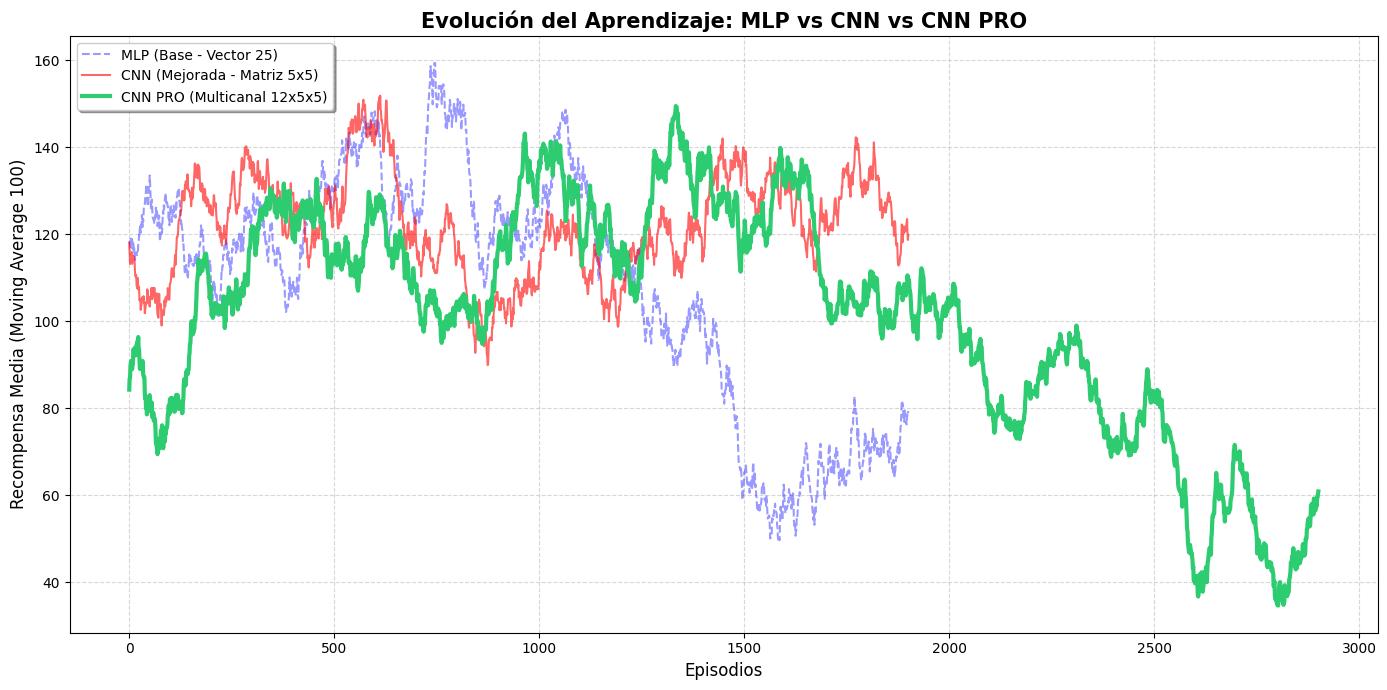

In [ ]:
plt.figure(figsize=(14, 7))

# MLP
if 'rewards' in locals():
    means_mlp = np.convolve(rewards, np.ones(100)/100, mode='valid')
    plt.plot(means_mlp, label='MLP (Base - Vector 25)', color='blue', alpha=0.4, linestyle='--')

# CNN
if 'rewards_cnn' in locals():
    means_cnn = np.convolve(rewards_cnn, np.ones(100)/100, mode='valid')
    plt.plot(means_cnn, label='CNN (Mejorada - Matriz 5x5)', color='red', alpha=0.6)

# CNN FINAL
if 'rewards_pro' in locals():
    means_pro = np.convolve(rewards_pro, np.ones(100)/100, mode='valid')
    plt.plot(means_pro, label='CNN PRO (Multicanal 12x5x5)', color='#2ecc71', linewidth=3)

# Configuración estética
plt.title('Evolución del Aprendizaje: MLP vs CNN vs CNN PRO', fontsize=15, fontweight='bold')
plt.xlabel('Episodios', fontsize=12)
plt.ylabel('Recompensa Media (Moving Average 100)', fontsize=12)
plt.legend(loc='upper left', shadow=True)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

2. Modelo final contra si mismo

In [ ]:
def simulate_pro_vs_pro(trained_model, max_moves=100, temperature=0.1):
    """
    Simulación de auto-juego para el modelo multicanal.
    """
    env_test = GardnerChessEnv()
    state = env_test.reset()
    done, moves, r = False, 0, 0

    handle = display(HTML(get_board_html_5x5(env_test.board, 0, 1, 0)), display_id=True)

    while not done and moves < max_moves:
        mask = env_test.get_action_mask()
        legal_indices = np.where(mask == 1)[0]

        if len(legal_indices) == 0: break

        with torch.no_grad():
            q_vals = trained_model(state)

            # Aplicamos Softmax para variedad táctica
            legal_q_values = q_vals[0][legal_indices]
            probs = F.softmax(legal_q_values / temperature, dim=0)

            action = np.random.choice(legal_indices, p=probs.cpu().numpy())

        state, r, done = env_test.step(action)
        moves += 1

        # Actualización visual (env_test.turn ya cambió, así que mostramos el bando que movió)
        handle.update(HTML(get_board_html_5x5(env_test.board, moves, env_test.turn * -1, r, done)))
        time.sleep(0.6)


simulate_pro_vs_pro(model_pro, temperature=0.4)

5,♕,,♕,,
4,,,,,♚
3,,,,,
2,♙,,♔,,
1,♖,,,,
,A,B,C,D,E


3. Modelo FInal (Blancas) vs MLP (Negras)

In [ ]:
def play_pro_vs_mlp(model_white, model_black, max_moves=100, temperature=0.1):
    """
    Duelo entre la arquitectura PRO (Multicanal) y el MLP (Base)
    """
    env_battle = GardnerChessEnv()
    state = env_battle.reset()
    done, moves, r = False, 0, 0

    # Manejador visual
    handle = display(HTML(get_board_html_5x5(env_battle.board, 0, 1, 0)), display_id=True)

    while not done and moves < max_moves:
        # Elegir el modelo según el turno
        # Turno 1 (Blancas): Modelo PRO | Turno -1 (Negras): MLP Base
        current_model = model_white if env_battle.turn == 1 else model_black

        mask = env_battle.get_action_mask()
        legal_indices = np.where(mask == 1)[0]

        if len(legal_indices) == 0: break

        with torch.no_grad():
            # Ambos modelos reciben el mismo 'state' [1, 25]
            # El Modelo PRO lo convertirá internamente a 12 canales
            q_values = current_model(state)

            # Aplicamos Softmax para evitar bloqueos
            legal_q_values = q_values[0][legal_indices]
            probs = F.softmax(legal_q_values / temperature, dim=0)
            action = np.random.choice(legal_indices, p=probs.cpu().numpy())

        state, r, done = env_battle.step(action)
        moves += 1

        # Actualización visual (env_battle.turn * -1 para mostrar quién movió)
        handle.update(HTML(get_board_html_5x5(env_battle.board, moves, env_battle.turn * -1, r, done)))
        time.sleep(0.6)


play_pro_vs_mlp(model_pro, model, temperature=0.3)

5,,,,,
4,,,♚,,♟
3,,,♜,,♙
2,,,,♔,
1,,,,,
,A,B,C,D,E


4. Modelo Final (Blancas) vs CNN(Negras)

In [ ]:
def play_pro_vs_cnn(model_pro_white, model_cnn_black, max_moves=100, temperature=0.1):
    """
    Duelo de arquitecturas avanzadas.
    La PRO usa 12 canales, la CNN usa 1 canal (matriz 5x5).
    """
    env_battle = GardnerChessEnv()
    state = env_battle.reset()
    done, moves, r = False, 0, 0

    # Manejador visual
    handle = display(HTML(get_board_html_5x5(env_battle.board, 0, 1, 0)), display_id=True)

    while not done and moves < max_moves:
        # Selección de modelo por turno
        current_model = model_pro_white if env_battle.turn == 1 else model_cnn_black

        mask = env_battle.get_action_mask()
        legal_indices = np.where(mask == 1)[0]
        if len(legal_indices) == 0: break

        with torch.no_grad():
            # El modelo PRO reestructura el tablero a 12 canales automáticamente
            # El modelo CNN lo reestructura a 1x5x5 automáticamente
            q_values = current_model(state)

            # Aplicamos Softmax
            legal_q_values = q_values[0][legal_indices]
            probs = F.softmax(legal_q_values / temperature, dim=0)
            action = np.random.choice(legal_indices, p=probs.cpu().numpy())

        state, r, done = env_battle.step(action)
        moves += 1

        # Actualización visual
        handle.update(HTML(get_board_html_5x5(env_battle.board, moves, env_battle.turn * -1, r, done)))
        time.sleep(0.6)


play_pro_vs_cnn(model_pro, model_cnn, temperature=0.3)

5,♜,♘,,,♚
4,♟,♟,♟,♕,♟
3,,,♟,,
2,♙,,♙,,♙
1,♖,,♗,,♔
,A,B,C,D,E


5. Recuento partidas entre modelos



In [ ]:
def get_action_tournament(model, state, mask, temperature=0.4):
    with torch.no_grad():
        q_values = model(state)
        # Aplicamos la máscara
        q_values[0][mask == 0] = -1e9

        # Softmax para elegir entre las mejores jugadas con un poco de azar
        probs = F.softmax(q_values / temperature, dim=1)
        action = torch.multinomial(probs, 1).item()
    return action

def run_tournament_pro(models_dict, games_per_match=50):
    """
    Versión mejorada del torneo para comparar MLP, CNN y PRO.
    """
    results = {}
    model_names = list(models_dict.keys())

    for i in range(len(model_names)):
        for j in range(len(model_names)):
            if i == j: continue

            m1_name, m2_name = model_names[i], model_names[j]
            match_name = f"{m1_name} vs {m2_name}"
            wins, draws, losses = 0, 0, 0

            print(f"Iniciando: {match_name}...")

            for _ in range(games_per_match):
                env = GardnerChessEnv()
                state = env.reset()
                done = False

                while not done:
                    mask = env.get_action_mask()
                    if np.sum(mask) == 0: break

                    # Turno Blancas (Modelo 1)
                    if env.turn == 1:
                        action = get_action_tournament(models_dict[m1_name], state, mask)
                    # Turno Negras (Modelo 2)
                    else:
                        action = get_action_tournament(models_dict[m2_name], state, mask)

                    state, reward, done = env.step(action)

                # Resultado final
                if done:
                    if reward >= 150: # Victoria por Mate (ajustado a tu escala)
                        if env.turn == -1: wins += 1 # Ganó Blancas (m1)
                        else: losses += 1 # Ganó Negras (m2)
                    elif reward <= -150: # Derrota/Empate por penalización
                        draws += 1
                    else:
                        draws += 1
                else:
                    draws += 1

            results[match_name] = (wins, draws, losses)
            print(f"{match_name}: {wins}V - {draws}E - {losses}D")

    return results

competicion = {
    "MLP": model,
    "CNN_Base": model_cnn,
    "PRO_Final": model_pro
}

resultados_finales = run_tournament_pro(competicion, games_per_match=50)

Iniciando: MLP vs CNN_Base...
MLP vs CNN_Base: 0V - 50E - 0D
Iniciando: MLP vs PRO_Final...
MLP vs PRO_Final: 1V - 47E - 2D
Iniciando: CNN_Base vs MLP...
CNN_Base vs MLP: 50V - 0E - 0D
Iniciando: CNN_Base vs PRO_Final...
CNN_Base vs PRO_Final: 35V - 14E - 1D
Iniciando: PRO_Final vs MLP...
PRO_Final vs MLP: 5V - 44E - 1D
Iniciando: PRO_Final vs CNN_Base...
PRO_Final vs CNN_Base: 46V - 4E - 0D


6. Test para ver si la IA puede con un jugador aleatorio

Ia Jugando de Blancas

In [ ]:
def test_vs_random(trained_model, n_games=50, model_name="Modelo"):
    wins, losses, draws = 0, 0, 0

    print(f" Evaluando {model_name} en {n_games} partidas...")

    for _ in range(n_games):
        env = GardnerChessEnv()
        state = env.reset()
        done = False
        r = 0

        while not done:
            mask = env.get_action_mask()
            legal = np.where(mask == 1)[0]
            if len(legal) == 0: break

            if env.turn == 1: # IA (Blancas)
                with torch.no_grad():
                    q = trained_model(state)
                    q[0][mask == 0] = -1e9
                    action = q.max(1)[1].item()
            else: # Rival Aleatorio (Negras)
                action = np.random.choice(legal)

            state, r, done = env.step(action)

        # Lógica de clasificación basada en las recompensas
        if r >= 150:
            wins += 1
        elif r <= -150:
            losses += 1
        else:
            draws += 1

    # Cálculos finales
    win_pct = (wins / n_games) * 100
    loss_pct = (losses / n_games) * 100
    draw_pct = (draws / n_games) * 100

    print(f"\n RESULTADOS FINAL: {model_name}")
    print(f"{'─' * 30}")
    print(f"🏆 Victorias: {wins} ({win_pct:.1f}%)")
    print(f"💀 Derrotas:  {losses} ({loss_pct:.1f}%)")
    print(f"🤝 Empates:   {draws} ({draw_pct:.1f}%)")
    print(f"{'─' * 30}\n")

    return wins, losses, draws

# Ejecutar evaluación para ambos modelos
results_pro = test_vs_random(model_pro, n_games=50, model_name="MODELO PRO (CNN 2 Capas)")
results_cnn = test_vs_random(model_cnn, n_games=50, model_name="MODELO SIMPLE (CNN 1 Capa)")
results_mlp = test_vs_random(model, n_games=50, model_name="MODELO MLP")

 Evaluando MODELO PRO (CNN 2 Capas) en 50 partidas...

 RESULTADOS FINAL: MODELO PRO (CNN 2 Capas)
──────────────────────────────
🏆 Victorias: 16 (32.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   34 (68.0%)
──────────────────────────────

 Evaluando MODELO SIMPLE (CNN 1 Capa) en 50 partidas...

 RESULTADOS FINAL: MODELO SIMPLE (CNN 1 Capa)
──────────────────────────────
🏆 Victorias: 21 (42.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   29 (58.0%)
──────────────────────────────

 Evaluando MODELO MLP en 50 partidas...

 RESULTADOS FINAL: MODELO MLP
──────────────────────────────
🏆 Victorias: 10 (20.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   40 (80.0%)
──────────────────────────────



IA jugando de Negras

In [ ]:
def test_vs_random(trained_model, n_games=50, model_name="Modelo"):
    wins, losses, draws = 0, 0, 0

    print(f" Evaluando {model_name} en {n_games} partidas...")

    for _ in range(n_games):
        env = GardnerChessEnv()
        state = env.reset()
        done = False
        r = 0

        while not done:
            mask = env.get_action_mask()
            legal = np.where(mask == 1)[0]
            if len(legal) == 0: break

            if env.turn == 0: # IA (Negras)
                with torch.no_grad():
                    q = trained_model(state)
                    q[0][mask == 0] = -1e9
                    action = q.max(1)[1].item()
            else: # Rival Aleatorio (Negras)
                action = np.random.choice(legal)

            state, r, done = env.step(action)

        # Lógica de clasificación basada en tus recompensas
        if r >= 150:
            wins += 1
        elif r <= -150:
            losses += 1
        else:
            draws += 1

    # Cálculos finales
    win_pct = (wins / n_games) * 100
    loss_pct = (losses / n_games) * 100
    draw_pct = (draws / n_games) * 100

    print(f"\n RESULTADOS FINAL: {model_name}")
    print(f"{'─' * 30}")
    print(f"🏆 Victorias: {wins} ({win_pct:.1f}%)")
    print(f"💀 Derrotas:  {losses} ({loss_pct:.1f}%)")
    print(f"🤝 Empates:   {draws} ({draw_pct:.1f}%)")
    print(f"{'─' * 30}\n")

    return wins, losses, draws

# Ejecutar evaluación para ambos modelos
results_pro = test_vs_random(model_pro, n_games=50, model_name="MODELO PRO (CNN 2 Capas)")
results_cnn = test_vs_random(model_cnn, n_games=50, model_name="MODELO SIMPLE (CNN 1 Capa)")
results_mlp = test_vs_random(model, n_games=50, model_name="MODELO MLP")

 Evaluando MODELO PRO (CNN 2 Capas) en 50 partidas...

 RESULTADOS FINAL: MODELO PRO (CNN 2 Capas)
──────────────────────────────
🏆 Victorias: 13 (26.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   37 (74.0%)
──────────────────────────────

 Evaluando MODELO SIMPLE (CNN 1 Capa) en 50 partidas...

 RESULTADOS FINAL: MODELO SIMPLE (CNN 1 Capa)
──────────────────────────────
🏆 Victorias: 17 (34.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   33 (66.0%)
──────────────────────────────

 Evaluando MODELO MLP en 50 partidas...

 RESULTADOS FINAL: MODELO MLP
──────────────────────────────
🏆 Victorias: 14 (28.0%)
💀 Derrotas:  0 (0.0%)
🤝 Empates:   36 (72.0%)
──────────────────────────────



### Bloque 12: Conclusiones Finales Análisis del Experimento y Lecciones Aprendidas

Tras completar el ciclo de desarrollo, entrenamiento y evaluación de las tres arquitecturas propuestas (MLP, CNN Simple y CNN PRO), se han extraído las siguientes conclusiones técnicas:

### **1. Evolución de la Percepción Espacial**
* **MLP (Baseline):** Se confirmó que el procesamiento lineal de un tablero de ajedrez es ineficiente. Al ignorar la topología del tablero, el modelo MLP no logró generalizar patrones básicos, demostrando que el ajedrez requiere de un **sesgo inductivo espacial** (proporcionado por las convoluciones).
* **CNN (Simple y PRO):** El salto a arquitecturas convolucionales permitió al agente entender la geometría del juego. La capacidad de detectar amenazas en diagonales y filas se tradujo en una política de capturas mucho más coherente.

### **2. Análisis de Rendimiento Detallado**

Tras realizar una batería de pruebas de 50 partidas por cada escenario, los resultados ofrecen una visión clara sobre la jerarquía de los modelos y el impacto de la arquitectura en el aprendizaje.

#### 2.1. Dominio en el Tablero: Modelos vs. Modelos
Los enfrentamientos directos revelan la  brecha de rendimiento entre las arquitecturas:
* **CNN Simple como potencia ofensiva:** Al jugar con **Blancas**, la CNN Simple aplastó al MLP con un récord perfecto de **50 Victorias - 0 Derrotas**. Además, demostró ser superior a la versión PRO en este escenario concreto con **35 victorias y 1 derrota**.
* **CNN PRO con mejor iniciativa:** Cuando el modelo PRO jugó con **Blancas**, demostró su superioridad técnica sobre la CNN Simple con un contundente **46 Victorias - 0 Derrotas**, lo que sugiere que su arquitectura más profunda es capaz de encontrar rutas de victoria más sólidas cuando tiene la iniciativa del primer movimiento.
* **El estancamiento del MLP:** El modelo MLP fue incapaz de ganar una sola partida como blancas contra la CNN Simple, forzando empates en el mejor de los casos.

#### 2.2. IA vs. Jugador Aleatorio (Consistencia)
La evaluación contra un oponente aleatorio confirma que todos los modelos han superado el umbral del azar (ninguno sufrió derrotas), pero con matices de eficiencia:
* **Eficacia con Blancas:** La **CNN Simple** es la más letal con un **42% de victorias**, seguida de la PRO (32%) y el MLP (20%).
* **Eficacia con Negras:** Curiosamente, el **MLP** mostró mejor desempeño defensivo/ofensivo como negras (**28% de victorias**) que como blancas. Esto indica que el MLP aprendió mejores patrones defensivos.

#### 2.3. El Problema del "Muro de las Tablas"
A pesar de la superioridad material, el índice de empates sigue siendo el factor dominante:
* En enfrentamientos de nivel similar (IA vs IA), las tablas superan el **88%** en muchos casos.
* **Conclusión técnica:** Los agentes han aprendido una **"defensa perfecta"** para su nivel (no cometen errores que lleven a la derrota), pero carecen de la capacidad de planificación necesaria para forzar el Jaque Mate contra una defensa mínimamente coherente.

#### 2.4 Veredicto Final del Experimento
1. **La CNN Simple** es la arquitectura más equilibrada para el tablero 5x5, logrando la mayor tasa de éxito frente a oponentes aleatorios.
2. **La CNN PRO** demuestra un potencial superior en la gestión de la iniciativa (Blancas vs IA), pero su complejidad no se traduce en una ventaja estadística clara al jugar como Negras o frente al azar en este número de episodios.
3. **Métrica de éxito:** El paso de una arquitectura MLP a una CNN Simple aumentó la efectividad ofensiva de la IA de un **20% a un 42%** (un incremento de más del doble de rendimiento).

### **3. El Desafío de la Recompensa Dispersa (*Sparse Rewards*)**  
* Se observa un alto índice de **empates (66% - 74%)**. Esto indica que los agentes han aprendido con éxito la **defensa y el valor material de Shannon** (evitan perder piezas), pero tienen dificultades para encontrar la secuencia exacta de movimientos que lleva al **Jaque Mate**.
* Como el Jaque Mate es un evento raro durante la exploración aleatoria, la red neuronal no recibe suficientes estímulos positivos de "victoria", lo que la lleva a conformarse con capturas tácticas sin llegar a cerrar la partida.

###**4. Estrategia B de Shannon y Limitaciones del DQN**
* Este proyecto valida la **Estrategia B (Intuición)**: las redes neuronales son excelentes para asignar valor a una posición actual. Sin embargo, se demuestra que el **Deep Q-Learning puro es insuficiente** para el ajedrez competitivo.
* Para alcanzar un nivel de maestría, la "intuición" de la red neuronal debe ser complementada con **algoritmos de búsqueda (como MCTS)** que permitan al agente "ver" el futuro.

### **Trabajo Futuro**
Para futuras iteraciones del proyecto, se proponen tres vías de mejora:
1.  **Integración de Monte Carlo Tree Search (MCTS):** Combinar la red CNN PRO con búsqueda por árbol para dotar al agente de capacidad de planificación.
2.  **Reward Shaping Dinámico:** Incrementar gradualmente el peso del Jaque Mate frente a las capturas materiales.
3.  **Entrenamiento contra Heurísticos:** Entrenar inicialmente al agente contra un rival aleatorio o un motor simple para acelerar la recolección de recompensas positivas.

---
**Proyecto finalizado con éxito como estudio experimental de arquitecturas de Reinforcement Learning aplicadas a entornos estratégicos de ajedrez.**